The aim of the classification task is to predict for each player a label that defines if s(he) isa high ranked player or a low ranked player (binary task) by exploiting the feature relatedto the rank of the players. 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls drive/MyDrive/dm_dataset/
!pip install pandas==1.3.4

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
country_codes.csv	 model_nn.pkl
female_players.csv	 model_nn_scaled.h5
height_dataset.csv	 model_nn_weights.h5
male_players.csv	 model_rf_no_toruney.pkl
matches.pkl		 model_rf.pkl
matches_tounery_id.pkl	 model_rule.pkl
model_ada.pkl		 model_svm.pkl
model_config.json	 nn
model_dt_no_tourney.pkl  players_dt_for_classification_nt.pkl
model_dt.pkl		 players_dt_for_classification.pkl
model_gaussian_nb.pkl	 players_for_classification.pkl
model_knn.pkl		 players.pkl
model_knn_scaled.pkl	 players_scaled_for_classification.pkl
model_mnb.pkl		 players_tourney_importance.pkl
model_nn1.h5		 tennis_matches.csv
model_nn.h5


## Seaborn (non runnare)

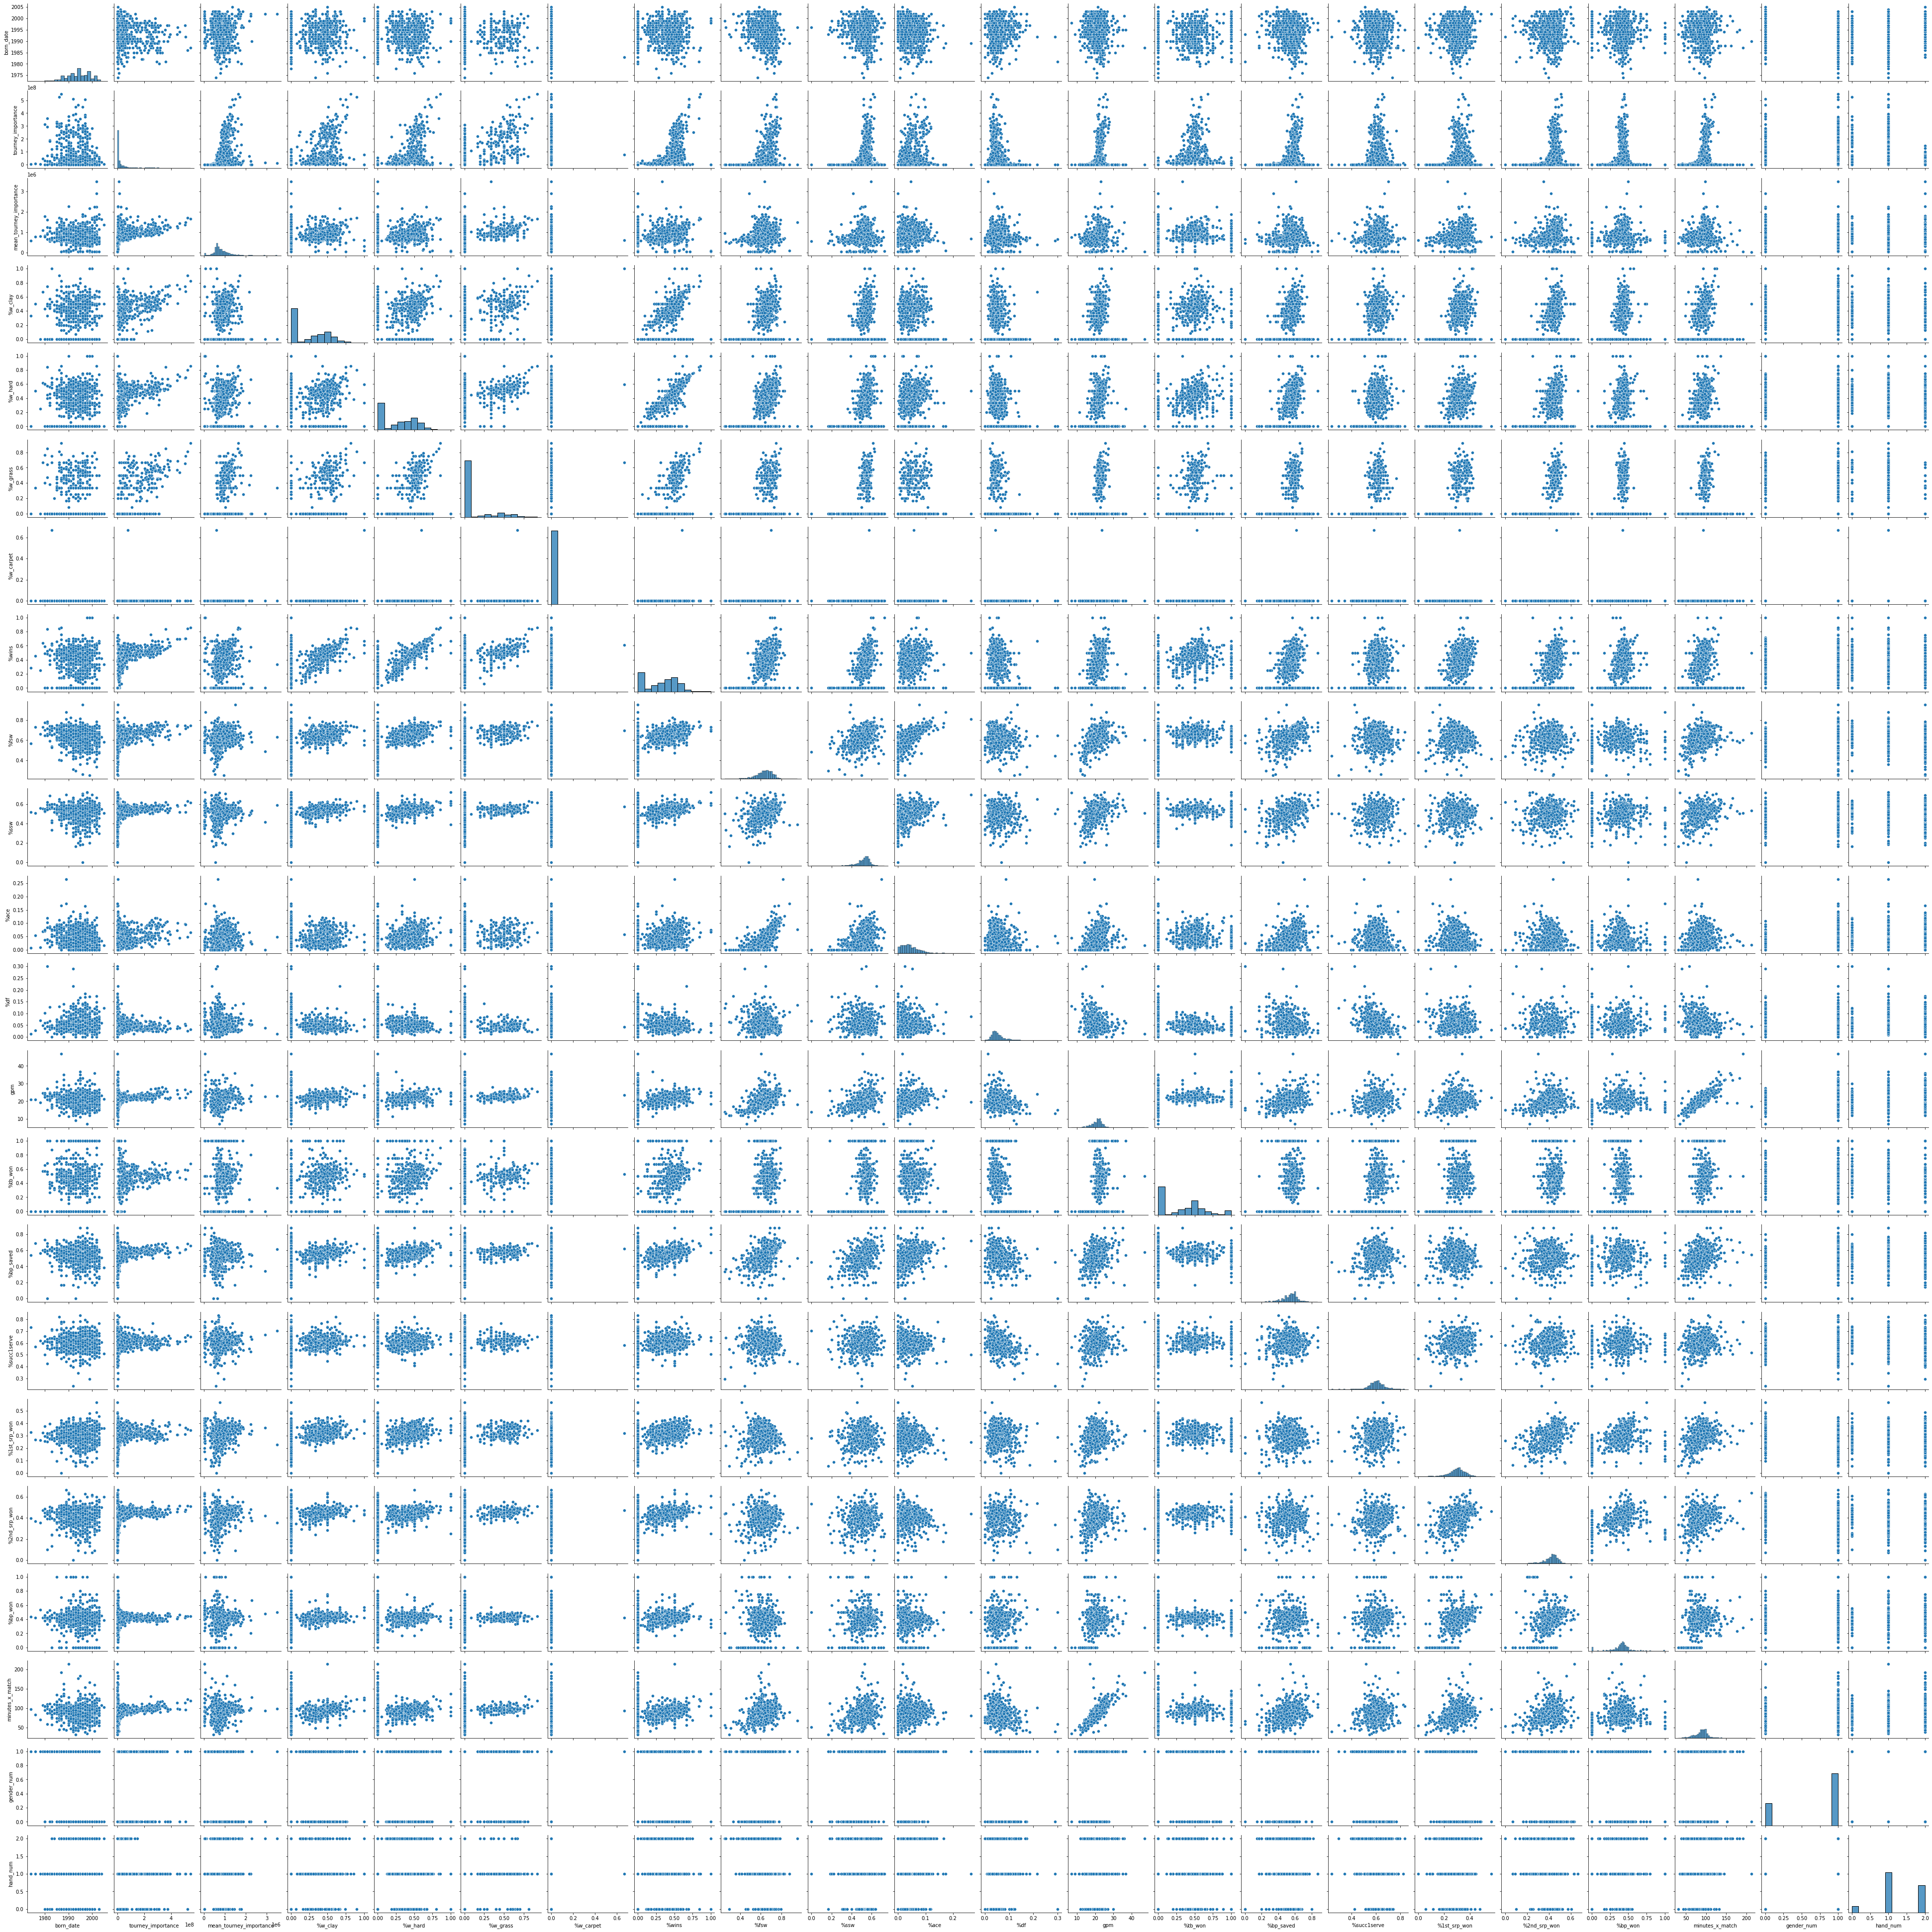

In [ ]:
import seaborn as sns
sns.pairplot(test_set_dt)

# Load the dataset and clean it

In [ ]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
import pickle

players = pd.read_pickle('drive/MyDrive/dm_dataset/players_tourney_importance.pkl') #loading the dataframe for Player Profile

We need to remove nan values, furthermore we remove:
- ht: since we have too few examples
- id: useless
- ioc, o_rank: since we dont want our model to use these features

In [ ]:
# we remove all the ones without rank
players = players[players['rank'].notna()]
players = players[players['o_rank'].notna()]
players = players.drop(columns=['ht','id'])
players = players.drop(columns=['ioc','o_rank'])
print(players.shape[0])
players.isna().sum()

3050


born_date                  0
rank                       0
hand                       0
gender                     0
tourney_importance         0
mean_tourney_importance    0
%w_clay                    0
%w_hard                    0
%w_grass                   0
%w_carpet                  0
%wins                      0
%fsw                       0
%ssw                       0
%ace                       0
%df                        0
gpm                        0
%tb_won                    0
%bp_saved                  0
%succ1serve                0
%1st_srp_won               0
%2nd_srp_won               0
%bp_won                    0
minutes_x_match            0
dtype: int64

## Stats


A look at the rank distribution over our dataset

In [ ]:
players['rank'].median()

487.0

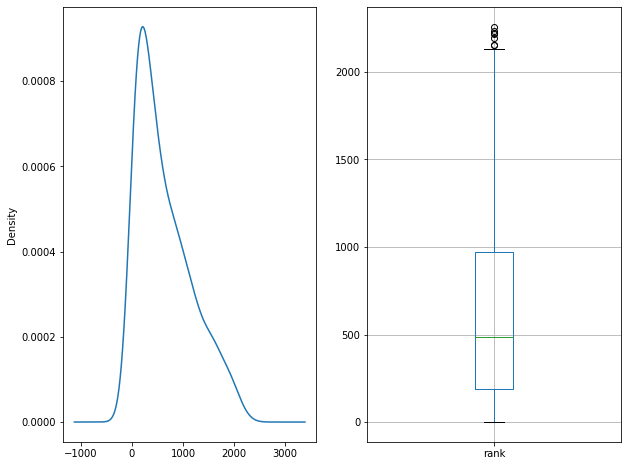

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,8))
players['rank'].plot.kde(bw_method=0.3, ax=ax1, label='rank')
players.boxplot(column=['rank'], ax=ax2)
plt.show()

## Preparing for classification

We divide the player by rank:
- higher than 436 -> strong player (label 0)
- lower than 436 -> weak player (label 1)

This value is the result of appliyng k-means with k=3 over these features: 'rank', 'tourney_importance', '%ace','%1st_srp_won' which divided the players in 3 main clusters according to the average rank per cluster. Since we only want two classes we take the middle class to split it, we can also see that the median (487) is close to it.

In [ ]:
#Dividing the player by rank before 436 strong player lower 436 weak player.
#This value is the result by appliyng k-means with k=3 over these features: 'rank', 'tourney_importance', '%ace','%1st_srp_won' which divided the players in 3 main clusters according to
#to the average rank per cluster. 
players.loc[players['rank']<=436,'rank'] = 0 #strong
players.loc[players['rank']>436,'rank']  = 1 #weak player
players['rank'] = players['rank'].astype(int)


players_dt = players.copy() # for dt
players['rank'].value_counts() #The two classes are good balanced.

1    1638
0    1412
Name: rank, dtype: int64

We can see that the classes are quite balanced thus we can avoid class weights.

### Hot encoding


Now we proceed to hot encode the categorical features for the models that require this.

In [ ]:
# Hot encoding of gender and hand
y = pd.get_dummies(players.gender, prefix='Gender')
players = pd.concat([players,y], axis=1)
y = pd.get_dummies(players.hand, prefix='hand')
players = pd.concat([players,y], axis=1)
players = players.drop(columns=['hand','gender'])

### Discretize the categorical variables
We can discretize the categorical variables and then use them for the classification task (ie DT).  
NB: for some classifiers it may not be a good practice (example: classifiers which use distance metrics for the classifications, such as KNN)

In [ ]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [ ]:
variables = ['gender', 'hand']
players_dt = discretize_data(players_dt, variables)

In [ ]:
#drop the categorical variables since we don't need them anymore 
players_dt.drop(columns=variables, axis=1,inplace=True)

In [ ]:
#the resulting dataset
players_dt.head()

born_date  rank  tourney_importance  ...  minutes_x_match  gender_num  hand_num
0     1982.0     0        1.128585e+08  ...        87.818182           0         1
1     1981.0     0        2.984865e+08  ...        87.182432           0         1
2     1983.0     0        1.790654e+07  ...        92.480000           0         1
3     1978.0     0        2.295915e+07  ...        92.480000           0         0
5     1980.0     1        1.658034e+06  ...       104.000000           0         1

[5 rows x 23 columns]

### Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
players_scaled = pd.DataFrame(scaler.fit_transform(players.values), index=players.index, columns=players.columns)

### Dataset splitting


In [ ]:
players_dt_nt=players_dt.drop(columns=['tourney_importance', 'mean_tourney_importance'])

to classify, we first need to split the dataset into train and test dataset.  
we can do so using train_test_split, in this case we select a stratified split to have a good balanced split between train and test.

In [ ]:
players.to_pickle("drive/MyDrive/dm_dataset/players_for_classification.pkl")
players_dt_nt.to_pickle("drive/MyDrive/dm_dataset/players_dt_for_classification_nt.pkl")
players_dt.to_pickle("drive/MyDrive/dm_dataset/players_dt_for_classification.pkl")
players_scaled.to_pickle("drive/MyDrive/dm_dataset/players_scaled_for_classification.pkl")

In [ ]:
# random_state = 1 is used so that we can reproduce all

from sklearn.model_selection import train_test_split
label = players.pop('rank')
train_set, test_set, train_label, test_label = train_test_split(players, label, stratify = label, test_size=0.30, random_state = 1 )

# for dt
label_dt = players_dt.pop('rank')
train_set_dt, test_set_dt, train_label_dt, test_label_dt = train_test_split(players_dt, label_dt, stratify = label_dt, test_size=0.30, random_state = 1)

# for dt without tourney importance
label_dt_nt = players_dt_nt.pop('rank')
train_set_dt_nt, test_set_dt_nt, train_label_dt_nt, test_label_dt_nt = train_test_split(players_dt_nt, label_dt_nt, stratify = label_dt_nt, test_size=0.30, random_state = 1)


# scaled
label_scaled = players_scaled.pop('rank')
train_set_scaled, test_set_scaled, train_label_scaled, test_label_scaled = train_test_split(players_scaled, label_scaled, stratify = label_scaled, test_size=0.30, random_state = 1)


## Utility functions

In [ ]:
#metrics computed on the test set
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['Strong Player', 'Weak Player']))

In [ ]:
# detect misclassification
def spot_errors(test_label, test_pred):
    spot_errors = []
    for i in range(len(test_label)):
        if test_label[i] != test_pred[i]:
            spot_errors.append('darkred')
        else:
            spot_errors.append('darkgray')
    return spot_errors

In [ ]:
def classification_visualizer(test_set, test_label, test_pred, classifier_name):
    f, axs = plt.subplots(nrows=1, ncols=3, figsize=(24,8))
    errors = spot_errors(test_label.values, test_pred)
    labels = [test_label.values, test_pred, errors]
    titles = ['True Labels', 'Predicted Labels', 'Misclassifications']

    for i in range(3):
        axs[i].scatter(test_set.iloc[:, 1].values, test_set.iloc[:, 10].values, c=labels[i], s=20, cmap='cividis')
        axs[i].set_title(titles[i])
        axs[i].set_xlabel(test_set.columns[1], fontdict={'fontsize': 'large'})
        axs[i].set_ylabel(test_set.columns[10], fontdict={'fontsize': 'large'})

    plt.suptitle(('Visualization of the ' + classifier_name + ' classifier on the test set'),
                 fontsize=24, fontweight='bold')

    plt.show()

# Classification with Naive Bayes

Naive Bayes is a classification algorithm based on the application of Bayes Theorem, it provides a probability to be classified, i.e. the probability for each data point to belong to a certain class. Its aim is to learn the posterior probability, i.e. maximize the likelihood.
The algorithm computes all the posterior probabilities and it chooses the label with the higher probability.  


## Gaussian

In Gaussian Naive Bayes the likelihood of the features is assumed to be Gaussian. By assuming the data to have a Gaussian distribution, we can estimate the parameter for this distribution (that are mean and variance) using maximum likelihood.

Since we aren't going to specify prior probabilities of the classes (because we want them to be adjusted according to the data) grid search for GNB model is not needed.


In [ ]:
#import, define and fit the model
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(GaussianNB(), {}, cv=5, verbose=10, scoring='accuracy')
grid = grid.fit(train_set, train_label)

In [ ]:
print(grid.best_params_)
gnb= grid.best_estimator_
print(grid.best_score_)

{}
0.8576112412177986


In [ ]:
#compute the performance of the model
train_pred_gnb = gnb.predict(train_set)
report_scores(train_label,train_pred_gnb)

               precision    recall  f1-score   support

Strong Player       0.96      0.73      0.83       988
  Weak Player       0.81      0.97      0.88      1147

     accuracy                           0.86      2135
    macro avg       0.88      0.85      0.85      2135
 weighted avg       0.88      0.86      0.86      2135



In [ ]:
import pickle
filename = "drive/MyDrive/dm_dataset/model_gaussian_nb.pkl"
pickle.dump(gnb, open(filename, 'wb'))

### Evaluation

In [ ]:
import pickle
filename = "drive/MyDrive/dm_dataset/model_gaussian_nb.pkl"
gnb = pickle.load(open(filename, 'rb'))

In [ ]:
#compute the performance of the model
#predict on the test set
test_pred_gnb = gnb.predict(test_set)
report_scores(test_label,test_pred_gnb)

               precision    recall  f1-score   support

Strong Player       0.93      0.74      0.83       424
  Weak Player       0.81      0.95      0.88       491

     accuracy                           0.86       915
    macro avg       0.87      0.85      0.85       915
 weighted avg       0.87      0.86      0.85       915



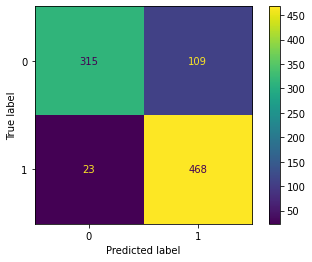

In [ ]:
# confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_label, test_pred_gnb)

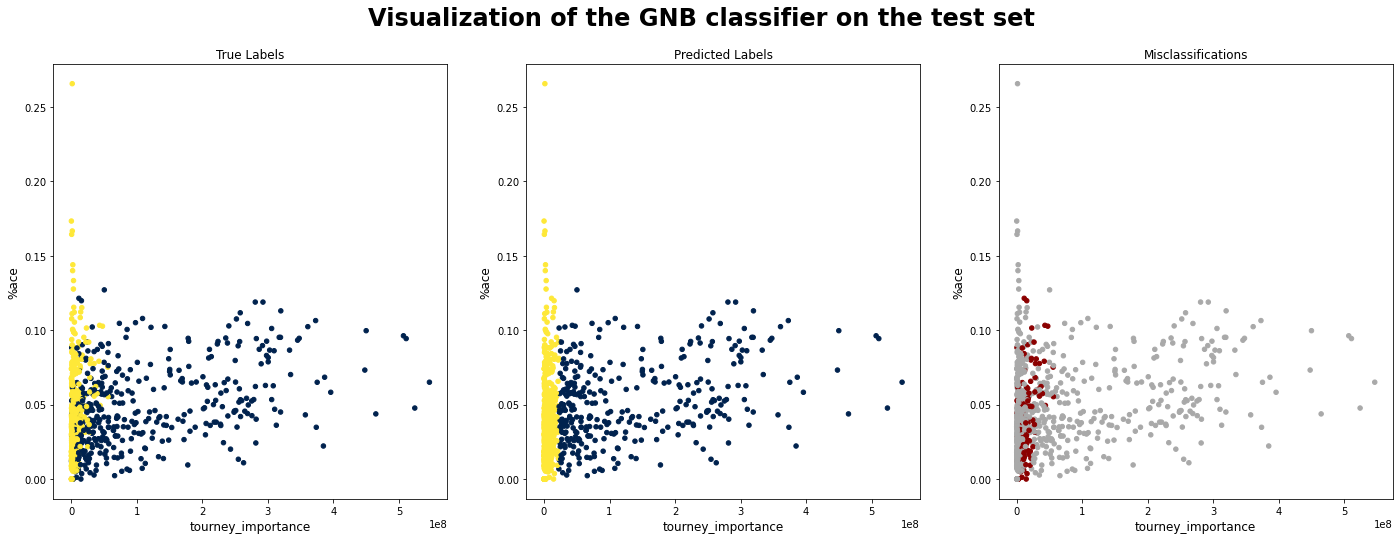

In [ ]:
classification_visualizer(test_set, test_label, test_pred_gnb, 'GNB')

## Multinomial

The distribution is parametrized by vectors of probability of a feature belonging to class.

The parameters are estimated by a smoothed version of maximum likelihood.

### Grid Search

In [ ]:
from sklearn.naive_bayes import MultinomialNB
param_dist = {
    "alpha": [0,1,2,3,5,6,7,8,9] # Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).
        } 
              
#define the number of iters
n_iter_search = 50

#define the grid search
grid_search = RandomizedSearchCV(MultinomialNB(), param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search.fit(train_set, train_label)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 9 is smaller than n_iter=50. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


RandomizedSearchCV(estimator=MultinomialNB(), n_iter=50, n_jobs=10,
                   param_distributions={'alpha': [0, 1, 2, 3, 5, 6, 7, 8, 9]},
                   scoring=make_scorer(accuracy_score))

In [ ]:
print(grid_search.best_params_)
mnb= grid_search.best_estimator_
print(grid_search.best_score_)

{'alpha': 0}
0.863231850117096


In [ ]:
train_pred_mnb=  mnb.predict(train_set)
report_scores(train_label,train_pred_mnb)

               precision    recall  f1-score   support

Strong Player       0.91      0.78      0.84       988
  Weak Player       0.83      0.93      0.88      1147

     accuracy                           0.86      2135
    macro avg       0.87      0.86      0.86      2135
 weighted avg       0.87      0.86      0.86      2135



In [ ]:
import pickle
filename = "drive/MyDrive/dm_dataset/model_mnb.pkl"
pickle.dump(mnb, open(filename, 'wb'))

### Evaluation

In [ ]:
import pickle
filename = "drive/MyDrive/dm_dataset/model_mnb.pkl"
mnb = pickle.load(open(filename, 'rb'))

In [ ]:
#compute the performance of the model
test_pred_mnb = mnb.predict(test_set)
report_scores(test_label,test_pred_mnb)

               precision    recall  f1-score   support

Strong Player       0.90      0.77      0.83       424
  Weak Player       0.83      0.92      0.87       491

     accuracy                           0.85       915
    macro avg       0.86      0.85      0.85       915
 weighted avg       0.86      0.85      0.85       915



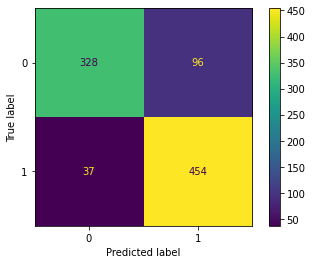

In [ ]:
# confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_label, test_pred_mnb)

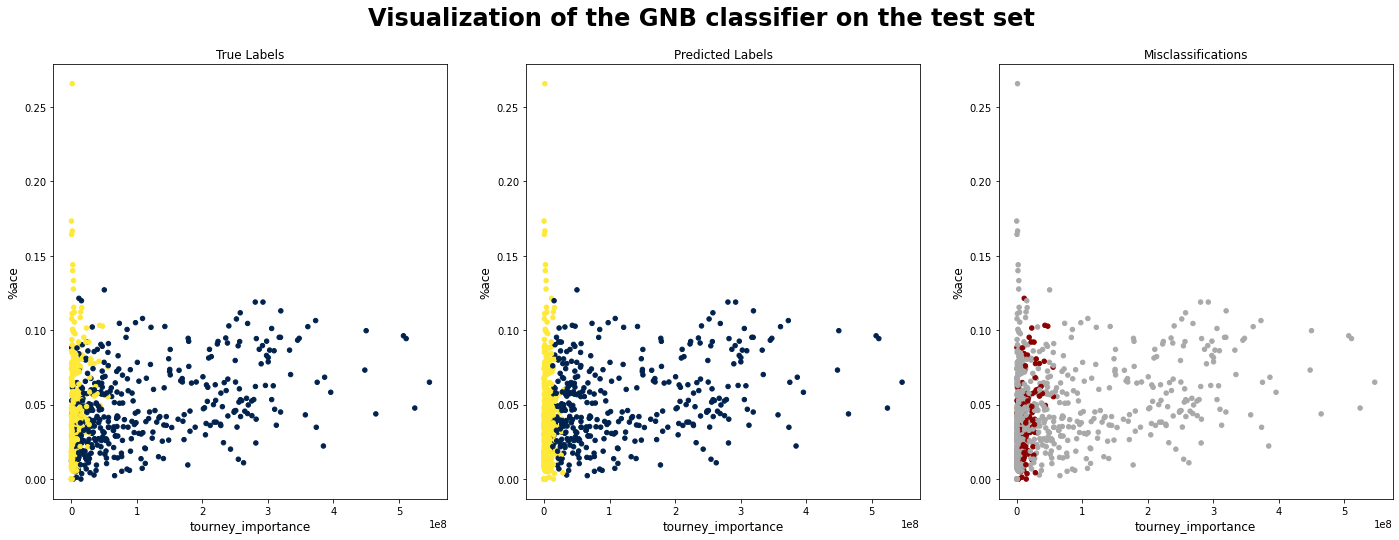

In [ ]:
classification_visualizer(test_set, test_label, test_pred_mnb, 'GNB')

## Final considerations

Naive Bayes results are not so far from other types of classifiers.
Pros
- Robust to isolated noise, irrelevant features, outliers and missing values
- Robust to overfitting
- Fast and simple

In this context, these advantages do not have much relevance: in fact, our dataset has already been cleaned up, and it is therefore already almost free of outliers, noise and missing values.
Cons
- Naive Bayes processes all features as independent and this may not hold for some attributes.

In our case, the problem of highly correlated features does not arise as they have already been eliminated during the preprocessing.

# Classification with Decision Tree

## Grid search

In [ ]:
#define a decision tree and fit it
from sklearn import tree
from sklearn.model_selection import GridSearchCV
tree_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20], 
             'min_samples_split':[i for i in range(2,10)], 'min_samples_leaf':[i for i in range(2,10)],
             'max_features':[i for i in range(4, len(players_dt.columns.values)+1, 2)]}
grid = GridSearchCV(tree.DecisionTreeClassifier(), tree_para, cv=5, verbose=10, scoring='accuracy')
grid = grid.fit(train_set_dt, train_label_dt)

Output streaming troncato alle ultime 5000 righe.
[CV 1/5; 13581/14080] START criterion=entropy, max_depth=20, max_features=8, min_samples_leaf=3, min_samples_split=6
[CV 1/5; 13581/14080] END criterion=entropy, max_depth=20, max_features=8, min_samples_leaf=3, min_samples_split=6;, score=0.876 total time=   0.0s
[CV 2/5; 13581/14080] START criterion=entropy, max_depth=20, max_features=8, min_samples_leaf=3, min_samples_split=6
[CV 2/5; 13581/14080] END criterion=entropy, max_depth=20, max_features=8, min_samples_leaf=3, min_samples_split=6;, score=0.883 total time=   0.0s
[CV 3/5; 13581/14080] START criterion=entropy, max_depth=20, max_features=8, min_samples_leaf=3, min_samples_split=6
[CV 3/5; 13581/14080] END criterion=entropy, max_depth=20, max_features=8, min_samples_leaf=3, min_samples_split=6;, score=0.869 total time=   0.0s
[CV 4/5; 13581/14080] START criterion=entropy, max_depth=20, max_features=8, min_samples_leaf=3, min_samples_split=6
[CV 4/5; 13581/14080] END criterion=en

In [ ]:
print(grid.best_params_)
dt= grid.best_estimator_
print(grid.best_score_)

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 20, 'min_samples_leaf': 9, 'min_samples_split': 7}
0.9096018735362998


In [ ]:
from sklearn import tree
#cross validation
#the score array for test/train scores on each cv split
#the time for fitting/scoring the estimator on the train set for each cv split
from sklearn.model_selection import cross_validate
import statistics 
#params = {'criterion': 'entropy', 'max_depth': 4, 'max_features': 18, 'min_samples_leaf': 3, 'min_samples_split': 7}
#dt = tree.DecisionTreeClassifier(**grid.best_params_)
#dt.fit(train_set_dt, train_label_dt)

scores = cross_validate(dt, train_set_dt, train_label_dt, cv=5, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))


Fit time  0.019893121719360352
Score time  0.0018054008483886718
Test score  0.9011709601873537
Train score  0.9180327868852459


In [ ]:
train_pred_dt = dt.predict(train_set_dt)
report_scores(train_label_dt, train_pred_dt)

               precision    recall  f1-score   support

Strong Player       0.93      0.90      0.92       988
  Weak Player       0.92      0.94      0.93      1147

     accuracy                           0.92      2135
    macro avg       0.92      0.92      0.92      2135
 weighted avg       0.92      0.92      0.92      2135



In [ ]:
import pickle
filename = "drive/MyDrive/dm_dataset/model_dt.pkl"
pickle.dump(dt, open(filename, 'wb'))

## Evaluation 

In [ ]:
import pickle
from sklearn import tree
filename = "drive/MyDrive/dm_dataset/model_dt.pkl"
dt = pickle.load(open(filename, 'rb'))

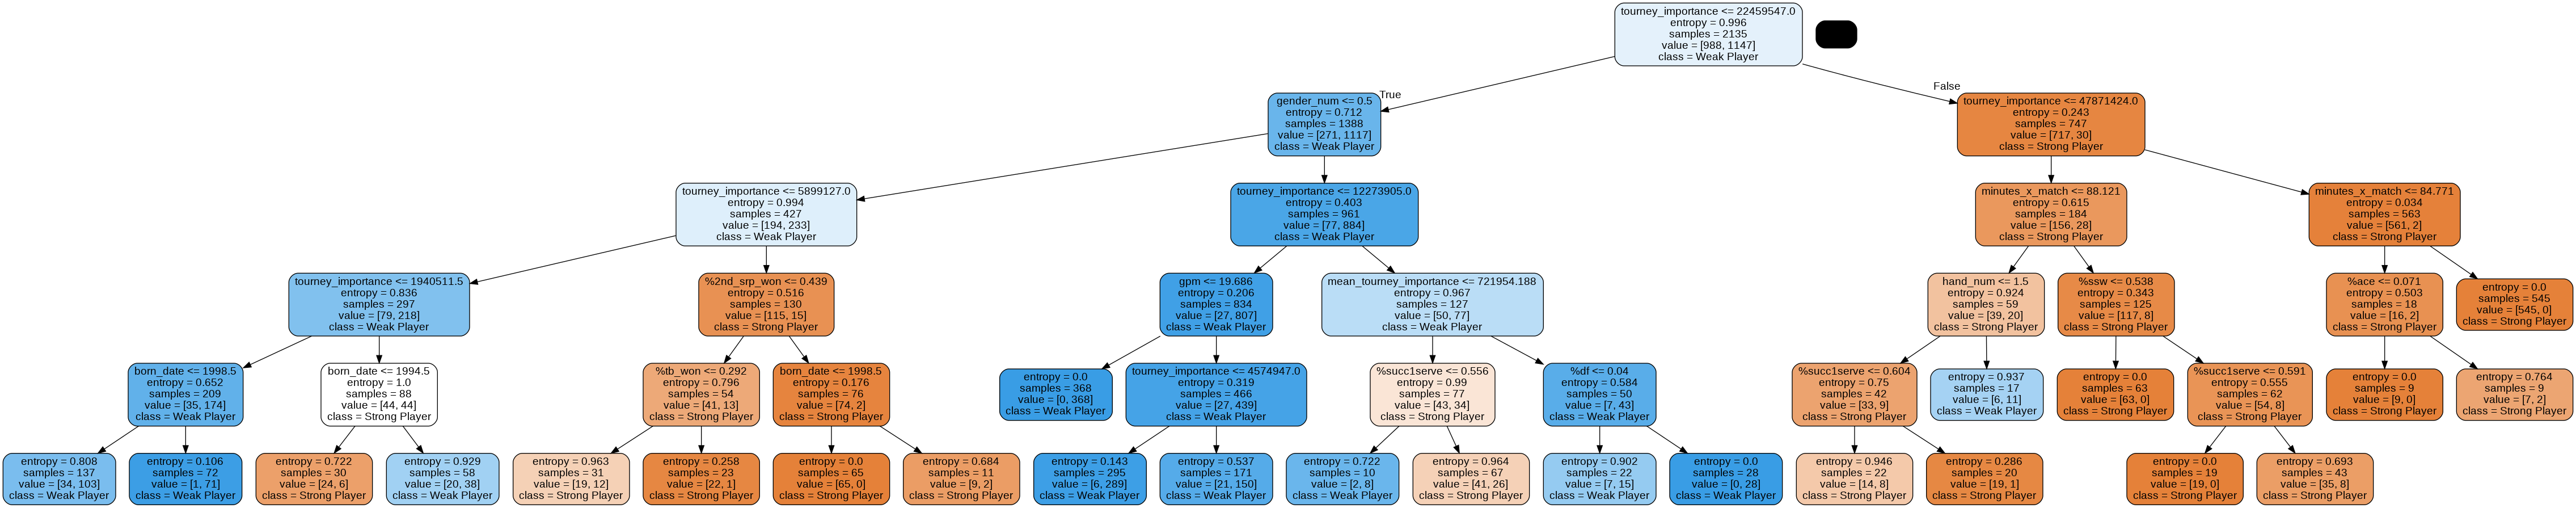

In [ ]:
#visualize the actual decision tree obtained 
import pydotplus 
from IPython.display import Image  

dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set_dt.columns),  
                         class_names=['Strong Player', 'Weak Player'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [ ]:
test_pred_dt = dt.predict(test_set_dt)
report_scores(test_label_dt, test_pred_dt)

               precision    recall  f1-score   support

Strong Player       0.89      0.88      0.89       424
  Weak Player       0.90      0.91      0.91       491

     accuracy                           0.90       915
    macro avg       0.90      0.90      0.90       915
 weighted avg       0.90      0.90      0.90       915



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


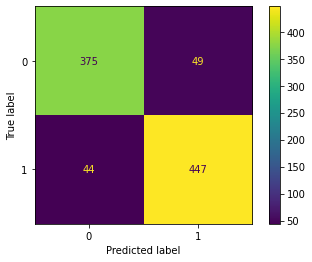

In [ ]:
#it is possible to plot the confusion matrix 
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_label_dt, test_pred_dt)
plot_confusion_matrix(dt, test_set_dt, test_label_dt)
plt.show() 

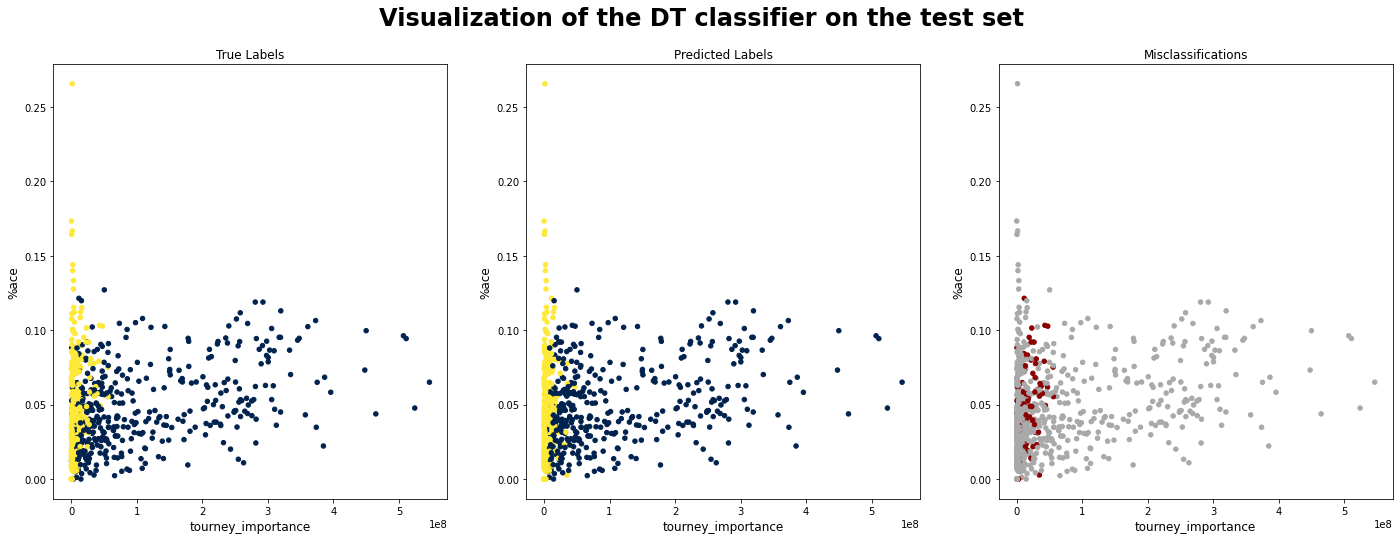

In [ ]:
classification_visualizer(test_set_dt, test_label_dt, test_pred_dt, 'DT')

## Final considerations

Decision tree is the best model for tabular data classification as we have studied, without considering the ensemble ones.  
Pro:
- Easy to understand
- Fast training
- No normalization required
- Handling of missing values

Cons:
- High overfitting risk
- Imbalanced dataset can cause a bias.	

# Classification with Random Forest

Results for single dt = {'criterion': 'entropy', 'max_depth': 4, 'max_features': 18, 'min_samples_leaf': 3, 'min_samples_split': 7}

## Grid search

In [ ]:
#to find the best set of parameter setting, we can run a grid search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
#define the parameters' values you want to try
param_dist = {"max_depth": [2,3,4,5,6,7,10],
              "max_features": sp_randint(10, len(players_dt.columns.values) + 1),
              "min_samples_split": sp_randint(2, 10),
              "min_samples_leaf": sp_randint(2, 10),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', 'balanced_subsample', None],
              "n_estimators":[20,30,40]}
#define the number of iters
n_iter_search = 200
#define the grid search
grid_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score), verbose=10)
#run the grid search
grid_search.fit(train_set_dt, train_label_dt)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=200, n_jobs=10,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         None],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 10],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3d05d72d50>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3d07a9ae50>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3d05d72cd0>,
                                        'n_estimators': [20, 30, 40]},
                   scoring=

In [ ]:
print('Best setting parameters\n', grid_search.cv_results_['params'][0])
print('\nMean of this setting\n', grid_search.cv_results_['mean_test_score'][0], 
      '\n\nStandard Deviation (std) of this setting\n', grid_search.cv_results_['std_test_score'][0])

Best setting parameters
 {'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 2, 'max_features': 19, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 20}

Mean of this setting
 0.8730679156908666 

Standard Deviation (std) of this setting
 0.012946393406168868


In [ ]:
print(grid_search.best_params_)
rf= grid_search.best_estimator_
print(grid_search.best_score_)

{'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 6, 'max_features': 14, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 40}
0.9142857142857143


In [ ]:
#prediction on the test test
train_pred_rf = rf.predict(train_set_dt)
#compute the performance of the model
report_scores(train_label_dt, train_pred_rf)

               precision    recall  f1-score   support

Strong Player       0.95      0.90      0.93       988
  Weak Player       0.92      0.96      0.94      1147

     accuracy                           0.94      2135
    macro avg       0.94      0.93      0.93      2135
 weighted avg       0.94      0.94      0.94      2135



In [ ]:
import pickle
filename = "drive/MyDrive/dm_dataset/model_rf.pkl"
pickle.dump(rf, open(filename, 'wb'))

## Evaluation


In [ ]:
import pickle
filename = "drive/MyDrive/dm_dataset/model_rf.pkl"
rf = pickle.load(open(filename, 'rb'))

In [ ]:
#prediction on the test test
test_pred_rf = rf.predict(test_set_dt)
#compute the performance of the model
report_scores(test_label_dt, test_pred_rf)

               precision    recall  f1-score   support

Strong Player       0.92      0.89      0.91       424
  Weak Player       0.91      0.93      0.92       491

     accuracy                           0.91       915
    macro avg       0.91      0.91      0.91       915
 weighted avg       0.91      0.91      0.91       915



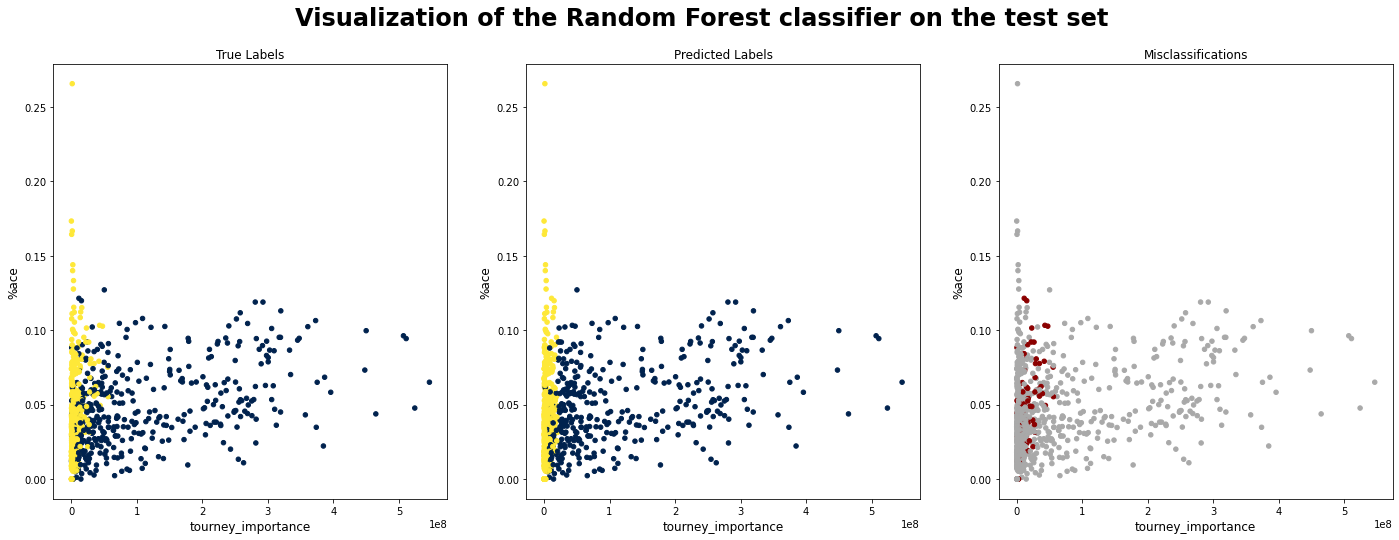

In [ ]:
classification_visualizer(test_set_dt, test_label_dt, test_pred_rf, 'Random Forest')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


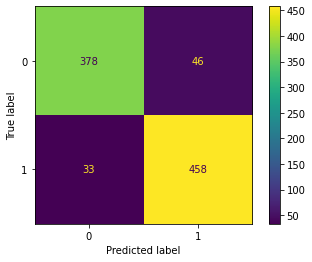

In [ ]:
#it is possible to plot the confusion matrix 
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(rf, test_set_dt, test_label_dt)
plt.show() 

In [ ]:
#plot_decision_boundary(train_set_dt, train_label_dt.values, rf, classifier_name='RF')

## Final considerations

As we have studied ensembling method are shown to improve the results over the models, in our case the improvement is very low since we think the accuracy reached is very close to the one achievable on the dataset with our labeling.  

# Ada Boost

## Grid Search

Adaboost has many parameters, we can select the base classifier, which can be a DecisionTree, a Logistic Regression and so on, we can select the number of estimators and the learning rate.

In [ ]:
#base = tree.DecisionTreeClassifier(max_depth=5)
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
params = {'n_estimators':[50, 100, 150, 200, 300],
             'learning_rate':[lr for lr in np.arange(0.1, 0.5, 0.1)],
          'base_estimator':[dt, None]}
grid_ada = GridSearchCV(AdaBoostClassifier(), params, cv=5, verbose=10)
grid_ada = grid_ada.fit(train_set_dt, train_label_dt)



Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=20,
                       min_samples_leaf=9, min_samples_split=7), learning_rate=0.1, n_estimators=50
[CV 1/5; 1/40] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=20,
                       min_samples_leaf=9, min_samples_split=7), learning_rate=0.1, n_estimators=50;, score=0.899 total time=   1.2s
[CV 2/5; 1/40] START base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=20,
                       min_samples_leaf=9, min_samples_split=7), learning_rate=0.1, n_estimators=50
[CV 2/5; 1/40] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=20,
                       min_samples_leaf=9, min_samples_split=7), learning_rate=0.1, n_estimators=50;, score=0.897 total time=   1.2s
[CV 3/5; 1/40] START base_estimator=

In [ ]:
print(grid_ada.best_params_)
clf = grid_ada.best_estimator_
print(grid_ada.best_score_)

{'base_estimator': None, 'learning_rate': 0.1, 'n_estimators': 150}
0.9110070257611241


In [ ]:
train_pred_clf = clf.predict(train_set_dt)
report_scores(train_label_dt, train_pred_clf)

               precision    recall  f1-score   support

Strong Player       0.93      0.88      0.91       988
  Weak Player       0.90      0.95      0.92      1147

     accuracy                           0.92      2135
    macro avg       0.92      0.92      0.92      2135
 weighted avg       0.92      0.92      0.92      2135



In [ ]:
import pickle
filename = "drive/MyDrive/dm_dataset/model_ada.pkl"
pickle.dump(clf, open(filename, 'wb'))

## Evaluation


In [ ]:
import pickle
filename = "drive/MyDrive/dm_dataset/model_ada.pkl"
clf = pickle.load(open(filename, 'rb'))

In [ ]:
test_pred_clf = clf.predict(test_set_dt)
report_scores(test_label_dt, test_pred_clf)

               precision    recall  f1-score   support

Strong Player       0.92      0.88      0.90       424
  Weak Player       0.90      0.93      0.92       491

     accuracy                           0.91       915
    macro avg       0.91      0.91      0.91       915
 weighted avg       0.91      0.91      0.91       915



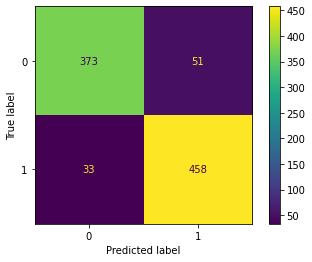

In [ ]:
# confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_label_dt, test_pred_clf)

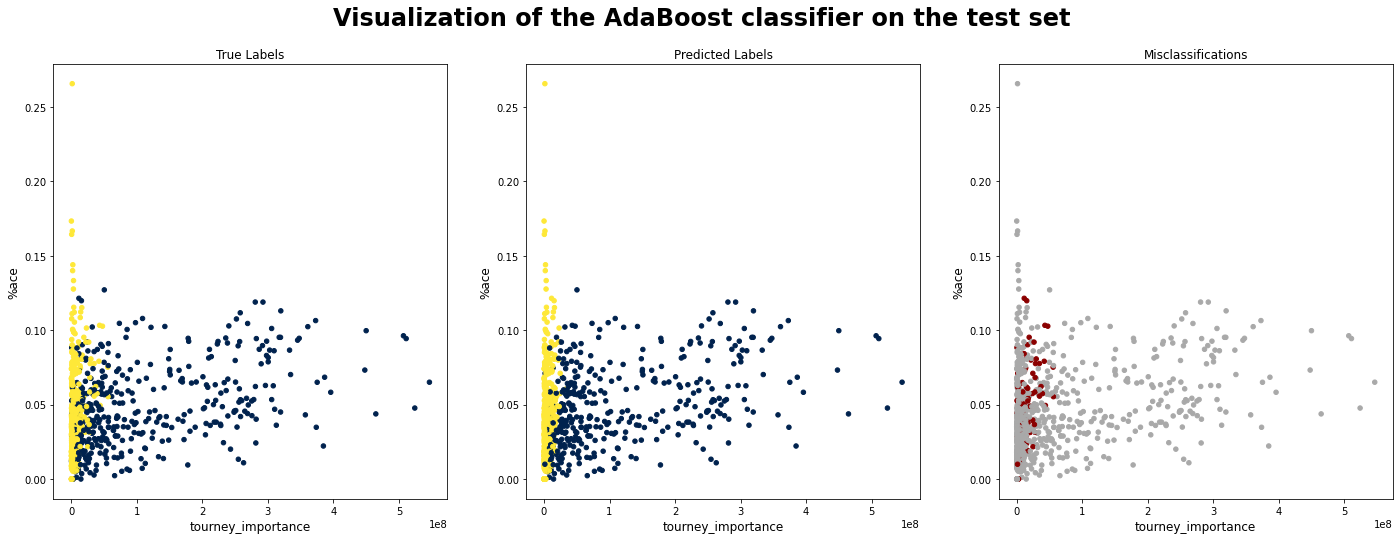

In [ ]:
classification_visualizer(test_set_dt, test_label_dt, test_pred_clf, 'AdaBoost')

# Neural Network

In [ ]:
!pip install git+git://github.com/keras-team/keras-tuner@master

  Cloning git://github.com/keras-team/keras-tuner (to revision master) to /tmp/pip-req-build-2nx5xjh1
  Running command git clone -q git://github.com/keras-team/keras-tuner /tmp/pip-req-build-2nx5xjh1
  Created wheel for keras-tuner: filename=keras_tuner-master-py3-none-any.whl size=102914 sha256=7aa8ce047ceacd377bd778aacbd71bf2c579171401cb026b1d90c986e38a84d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-7mokdx5q/wheels/4f/00/c1/78fde51c82276f606a96c313d91d969bc9dd7a1fbe545a8975
Failed to build keras-tuner
    Running setup.py install for keras-tuner ... done
  DEPRECATION: keras-tuner was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


## Grid Search

In [ ]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
import os
import tensorflow as tf

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 2, 4)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=256, step=32),
                activation=hp.Choice("activation", ["tanh", "sigmoid", 'relu']),
            )
        )
        if hp.Boolean("dropout"):
            model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(1, activation=hp.Choice("activation", ["sigmoid", "softmax"])))
    learning_rate = hp.Float("lr", min_value=0.01, max_value=0.2, sampling="log")
    lr_schedule = keras.optimizers.schedules.ExponentialDecay( initial_learning_rate=learning_rate, decay_steps=1000, decay_rate=0.9)
    hp_optimizer = hp.Choice('optimizer', values=['sgd', 'adamax'])

    if hp_optimizer == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
    elif hp_optimizer == 'adamax':
        optimizer = keras.optimizers.Adamax(learning_rate=lr_schedule)
    else:
        raise

    model.compile(
        optimizer=optimizer,
        loss="mean_squared_error",
        metrics=["accuracy"],
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=100, #distribution_strategy=strategy,
    executions_per_trial=5,
    overwrite=True)


tuner.search(train_set_scaled, train_label_scaled, epochs=200, batch_size=32, validation_split=0.2, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping("val_accuracy", patience=10)])

best_model = tuner.get_best_models()[0]

In [ ]:
# normalized
from sklearn.model_selection import RepeatedKFold, cross_val_score

best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
best_model = build_model(best_hps[0])
history = best_model.fit(train_set_scaled, train_label_scaled, epochs=200, batch_size=32, validation_split=0.2, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping("val_accuracy", patience=50)])

Epoch 1/200
54/54 [==============================] - 2s 18ms/step - loss: 0.1761 - accuracy: 0.7512 - val_loss: 0.1253 - val_accuracy: 0.8361
Epoch 2/200
54/54 [==============================] - 1s 13ms/step - loss: 0.1274 - accuracy: 0.8255 - val_loss: 0.0992 - val_accuracy: 0.8759
Epoch 3/200
54/54 [==============================] - 1s 10ms/step - loss: 0.1166 - accuracy: 0.8443 - val_loss: 0.0932 - val_accuracy: 0.8876
Epoch 4/200
54/54 [==============================] - 0s 7ms/step - loss: 0.1085 - accuracy: 0.8489 - val_loss: 0.0906 - val_accuracy: 0.8806
Epoch 5/200
54/54 [==============================] - 0s 7ms/step - loss: 0.1031 - accuracy: 0.8554 - val_loss: 0.0929 - val_accuracy: 0.8759
Epoch 6/200
54/54 [==============================] - 0s 6ms/step - loss: 0.1034 - accuracy: 0.8571 - val_loss: 0.0833 - val_accuracy: 0.8782
Epoch 7/200
54/54 [==============================] - 0s 7ms/step - loss: 0.1003 - accuracy: 0.8677 - val_loss: 0.0851 - val_accuracy: 0.8876
Epoch 8/20

best_model.

In [ ]:
print(best_hps[0].get_config())
print('accuracy: '+str(history.history['val_accuracy'][-1]))

{'space': [{'class_name': 'Int', 'config': {'name': 'num_layers', 'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': None}}, {'class_name': 'Int', 'config': {'name': 'units_0', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}}, {'class_name': 'Choice', 'config': {'name': 'activation', 'default': 'tanh', 'conditions': [], 'values': ['tanh', 'sigmoid', 'relu'], 'ordered': False}}, {'class_name': 'Boolean', 'config': {'name': 'dropout', 'default': False, 'conditions': []}}, {'class_name': 'Int', 'config': {'name': 'units_1', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}}, {'class_name': 'Float', 'config': {'name': 'lr', 'default': 0.01, 'conditions': [], 'min_value': 0.01, 'max_value': 0.2, 'step': None, 'sampling': 'log'}}, {'class_name': 'Choice', 'config': {'name': 'optimizer', 'default': 'sgd', 'conditions': [], 'values': ['sgd', 'adamax'], 'o

In [ ]:
train_pred_nn = (best_model.predict(train_set_scaled) > 0.5).astype("int32")
report_scores(train_label_scaled, train_pred_nn)

               precision    recall  f1-score   support

Strong Player       0.93      0.91      0.92       988
  Weak Player       0.93      0.94      0.93      1147

     accuracy                           0.93      2135
    macro avg       0.93      0.93      0.93      2135
 weighted avg       0.93      0.93      0.93      2135



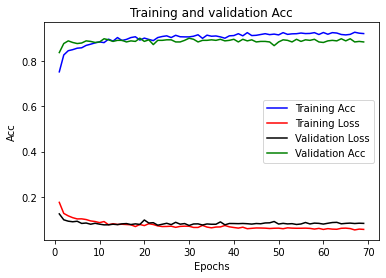

In [ ]:
# history = model.fit(x_train, y_train)
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training Acc')
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'black', label='Validation Loss')
plt.plot(epochs, val_acc, 'g', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
filename = "drive/MyDrive/dm_dataset/model_nn_scaled.h5"
best_model.save(filename, overwrite=True)

## Evaluation

In [ ]:
from keras.models import load_model
filename = "drive/MyDrive/dm_dataset/model_nn_scaled.h5"
best_model = load_model(filename)

In [ ]:
test_pred_nn = (best_model.predict(test_set_scaled) > 0.5).astype("int32")
report_scores(test_label_scaled, test_pred_nn)

               precision    recall  f1-score   support

Strong Player       0.90      0.90      0.90       424
  Weak Player       0.91      0.91      0.91       491

     accuracy                           0.91       915
    macro avg       0.91      0.91      0.91       915
 weighted avg       0.91      0.91      0.91       915



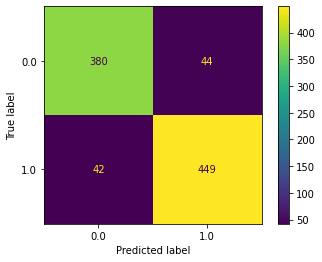

In [ ]:
# confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_label_scaled, test_pred_nn)

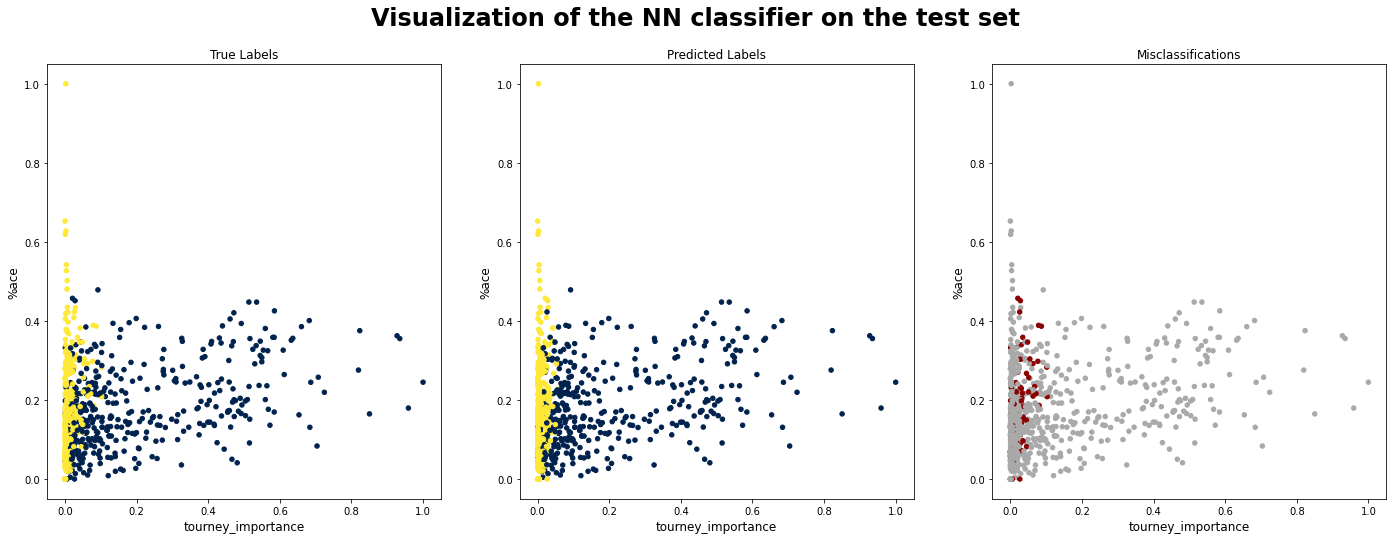

In [ ]:
classification_visualizer(test_set_scaled, test_label_scaled, test_pred_nn, 'NN')

## Final considerations

Pro:
- very flexible

Cons:
- different random weight initializations can lead to different validation accuracy
- it requires tuning a lot of hyperparameters: grid-search process can be very time-consuming
- it is sensitive to feature scaling: for this reason, a pre-processing phase is needed.



# Classification with K-nn

KNN works best with a dataset that is free of irrelevant and redundant attributes. The former add noise to the proximity measure while the latter introduce bias towards certain attributes.
Additionally, hot encoded features should be removed and the remaining may need to be resized to prevent distance measurements from being dominated by one of the attributes.  
Thus we use the normalized version of the training and test sets.


In [ ]:

hot_ecnoded_columns = ['Gender_Female',	'Gender_Male',	'hand_L',	'hand_R',	'hand_U']
#drop the categorical features
train_set_no_cat = train_set.loc[:,list(filter(lambda x: x not in hot_ecnoded_columns,train_set.columns.values))] 
test_set_no_cat = test_set.loc[:,list(filter(lambda x: x not in hot_ecnoded_columns,train_set.columns.values))]

# scaled one
train_set_scaled_no_cat = train_set.loc[:,list(filter(lambda x: x not in hot_ecnoded_columns,train_set_scaled.columns.values))] 
test_set_scaled_no_cat = test_set.loc[:,list(filter(lambda x: x not in hot_ecnoded_columns,train_set_scaled.columns.values))]

## Grid Search

The main hyperparameters are:
- k: number of neighbors
- metric: we use Minkowski that can represent different metrics by only varying p
- algorithm: to reduce the number of distance computations

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_para = {'n_neighbors':list(range(1, 10)),
            'algorithm':['auto', 'ball_tree'],
            'metric':['minkowski'],
            'p':list(range(1,4))}
  
# defining parameter range
grid = GridSearchCV(KNeighborsClassifier(), knn_para, cv=5, scoring='accuracy', return_train_score=False, verbose=10)
  
# fitting the model for grid search
grid=grid.fit(train_set_scaled_no_cat, train_label)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5; 1/54] START algorithm=auto, metric=minkowski, n_neighbors=1, p=1.......
[CV 1/5; 1/54] END algorithm=auto, metric=minkowski, n_neighbors=1, p=1;, score=0.775 total time=   0.0s
[CV 2/5; 1/54] START algorithm=auto, metric=minkowski, n_neighbors=1, p=1.......
[CV 2/5; 1/54] END algorithm=auto, metric=minkowski, n_neighbors=1, p=1;, score=0.822 total time=   0.0s
[CV 3/5; 1/54] START algorithm=auto, metric=minkowski, n_neighbors=1, p=1.......
[CV 3/5; 1/54] END algorithm=auto, metric=minkowski, n_neighbors=1, p=1;, score=0.829 total time=   0.0s
[CV 4/5; 1/54] START algorithm=auto, metric=minkowski, n_neighbors=1, p=1.......
[CV 4/5; 1/54] END algorithm=auto, metric=minkowski, n_neighbors=1, p=1;, score=0.824 total time=   0.0s
[CV 5/5; 1/54] START algorithm=auto, metric=minkowski, n_neighbors=1, p=1.......
[CV 5/5; 1/54] END algorithm=auto, metric=minkowski, n_neighbors=1, p=1;, score=0.792 total time=   0.1s
[CV 1/5;

In [ ]:
# examine the best model
print('Accuracy: ' + str(grid.best_score_))
print('Parameters: ' + str(grid.best_params_))
# no scaling
knn = grid.best_estimator_

Accuracy: 0.8580796252927401
Parameters: {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 7, 'p': 3}


In [ ]:
#prediction on the test test
train_pred_knn = knn.predict(train_set_scaled_no_cat)
#compute the performance of the model
report_scores(train_label_scaled,train_pred_knn)

               precision    recall  f1-score   support

Strong Player       0.91      0.82      0.86       988
  Weak Player       0.85      0.93      0.89      1147

     accuracy                           0.88      2135
    macro avg       0.88      0.87      0.88      2135
 weighted avg       0.88      0.88      0.88      2135



In [ ]:
import pickle
filename = "drive/MyDrive/dm_dataset/model_knn_scaled.pkl"
pickle.dump(knn, open(filename, 'wb'))

## Evaluation


In [ ]:
import pickle
filename = "drive/MyDrive/dm_dataset/model_knn_scaled.pkl"
knn = pickle.load(open(filename, 'rb'))

In [ ]:
#prediction on the test test
test_pred_knn = knn.predict(test_set_scaled_no_cat)
#compute the performance of the model
report_scores(test_label,test_pred_knn)

               precision    recall  f1-score   support

Strong Player       0.87      0.81      0.84       424
  Weak Player       0.84      0.89      0.87       491

     accuracy                           0.85       915
    macro avg       0.86      0.85      0.85       915
 weighted avg       0.86      0.85      0.85       915



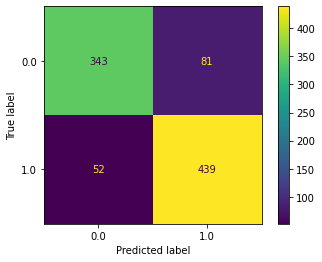

In [ ]:
# confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_label_scaled, test_pred_knn)

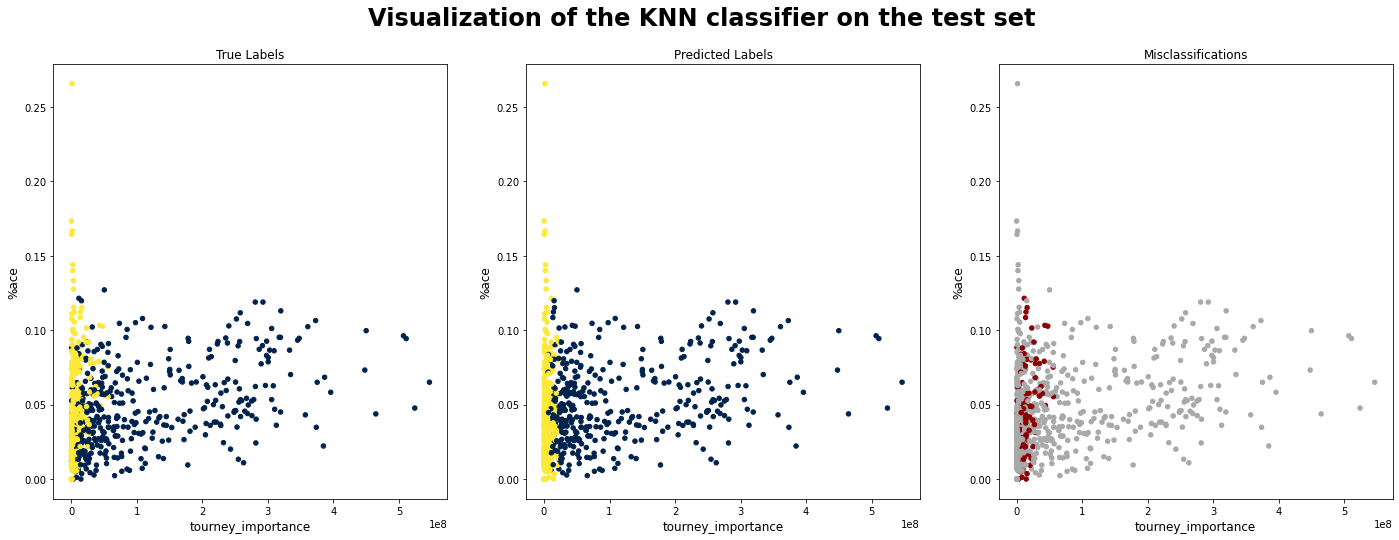

In [ ]:
classification_visualizer(test_set_scaled_no_cat, test_label_scaled, test_pred_knn, 'KNN')

# Classification with SVM

## Grid Search

In svm we use normalized data  
Since this classifier has many parameters, a grid search is required.
- kernel: determines the shape of the decision boundaries.
- C: regularization parameter. The strength of the regularization is inversely proportional to C.


In [ ]:
#linear,poly,rbf,sigmoid,precomputed
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm = SVC(random_state=1)
svm_para = [{'kernel':['rbf', 'sigmoid'],
            'C':[0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
            'gamma':['scale', 'auto'],
            'probability':[True]},
            {'kernel':['linear', 'poly'],
            'C':[0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
            'probability':[True]}]
# defining parameter range
grid_search = GridSearchCV(svm, svm_para, cv=5, scoring='accuracy', return_train_score=False, verbose=10)
  
# fitting the model for grid search
grid_search=grid_search.fit(train_set_scaled, train_label_scaled)

In [ ]:
# examine the best model
print('Accuracy: ' + str(grid_search.best_score_))
print('Parameters: ' + str(grid_search.best_params_))
svm = grid_search.best_estimator_

In [ ]:
train_pred_svm = svm.predict(train_set_scaled)
report_scores(train_label_scaled, train_pred_svm)

In [ ]:
import pickle
filename = "drive/MyDrive/dm_dataset/model_svm.pkl"
pickle.dump(svm, open(filename, 'wb'))

NameError: ignored

## Evaluation

In [ ]:
import pickle
filename = "drive/MyDrive/dm_dataset/model_svm.pkl"
svm = pickle.load(open(filename, 'rb'))

In [ ]:
test_pred_proba_svm = svm.predict_proba(test_set_scaled)
test_pred_svm = svm.predict(test_set_scaled)
report_scores(test_label_scaled,test_pred_svm)

NameError: ignored

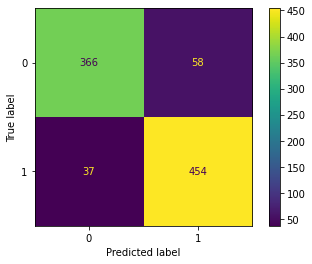

In [ ]:
# confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_label, test_pred_svm)

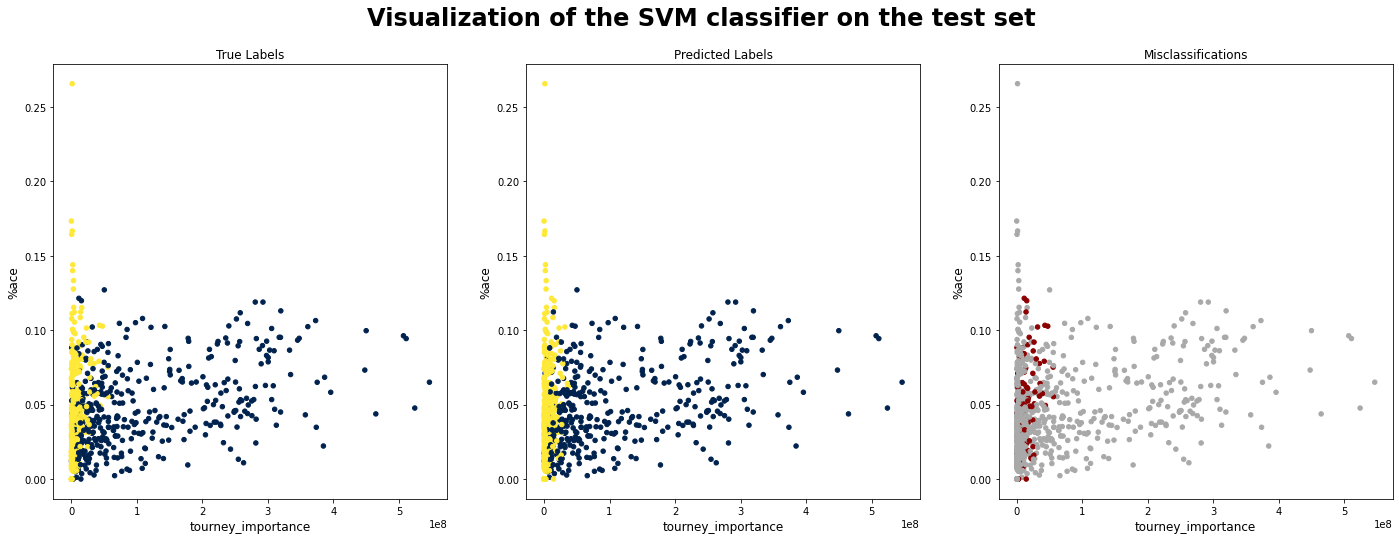

In [ ]:
classification_visualizer(test_set, test_label, test_pred_svm, 'SVM')

## Final considerations

SVM confirms to be a very powerful model for data classification, even with high number of features and so high-dimensionality of the dataset.

Advantages
- Effective in high dimensional spaces.
- Kernel flexibility: different Kernel functions can be specified for the decision function.
- Fast predictions

Disadvantages
- Scaling is almost a necessity otherwise features with higher values will dominate the distance omputations between the plane and support vectors.
- Over-fitting risk in choosing Kernel functions and regularization term.



# Classification with rule based 

In [ ]:
!pip install wittgenstein

     |████████████████████████████████| 124 kB 3.5 MB/s 


## Grid Search

In [ ]:
#we run a grid search to find the best configuration of parameters' values
import wittgenstein as lw
from sklearn.model_selection import GridSearchCV
ripper = lw.RIPPER()
param_grid = {"prune_size": [0, 0.1, 0.2, 0.3, 0.5, 0.6], "k": [1, 3, 5]}
grid_search = GridSearchCV(estimator=ripper, param_grid=param_grid, verbose=10)
grid_search.fit(train_set, train_label, class_feat='rank', pos_class=0)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5; 1/18] START k=1, prune_size=0..........................................
[CV 1/5; 1/18] END .............k=1, prune_size=0;, score=nan total time=   1.5s
[CV 2/5; 1/18] START k=1, prune_size=0..........................................
[CV 2/5; 1/18] END ...........k=1, prune_size=0;, score=0.667 total time=   1.3s
[CV 3/5; 1/18] START k=1, prune_size=0..........................................
[CV 3/5; 1/18] END ...........k=1, prune_size=0;, score=0.656 total time=   0.9s
[CV 4/5; 1/18] START k=1, prune_size=0..........................................
[CV 4/5; 1/18] END ...........k=1, prune_size=0;, score=0.672 total time=   0.9s
[CV 5/5; 1/18] START k=1, prune_size=0..........................................
[CV 5/5; 1/18] END ...........k=1, prune_size=0;, score=0.646 total time=   0.9s
[CV 1/5; 2/18] START k=1, prune_size=0.1........................................
[CV 1/5; 2/18] END .........k=1, prune_size=0.1;

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/wittgenstein/ripper.py", line 302, in fit
    random_state=self.random_state,
  File "/usr/local/lib/python3.7/dist-packages/wittgenstein/ripper.py", line 1123, in _cover_remaining_positives_cn
    random_state=random_state,
  File "/usr/local/lib/python3.7/dist-packages/w

GridSearchCV(estimator=<RIPPER(random_state=None, dl_allowance=64, max_total_conds=None, max_rules=None, prune_size=0.33, k=2, n_discretize_bins=10, verbosity=0, max_rule_conds=None)>,
             param_grid={'k': [1, 3, 5],
                         'prune_size': [0, 0.1, 0.2, 0.3, 0.5, 0.6]},
             verbose=10)

In [ ]:
print('Best parameters setting ', grid_search.cv_results_['params'][0])
print('Best score ', grid_search.best_score_)
ripper = grid_search.best_estimator_

Best parameters setting  {'k': 1, 'prune_size': 0.1}
Best score  0.8885245901639344


In [ ]:
ripper.out_model()

[[hand_U=0 ^ %w_grass=0.27-0.5 ^ tourney_importance=>199334733.19] V
[hand_U=0 ^ tourney_importance=91594188.91-199334733.19] V
[tourney_importance=34936947.6-91594188.91 ^ Gender_Female=1] V
[hand_U=0 ^ tourney_importance=>199334733.19] V
[tourney_importance=34936947.6-91594188.91 ^ hand_U=0] V
[tourney_importance=15310713.42-34936947.6 ^ Gender_Female=1] V
[Gender_Female=1 ^ tourney_importance=7722401.92-15310713.42 ^ %ssw=0.47-0.5] V
[Gender_Female=1 ^ tourney_importance=7722401.92-15310713.42] V
[tourney_importance=15310713.42-34936947.6 ^ born_date=<1987.0 ^ %succ1serve=0.6-0.62] V
[tourney_importance=15310713.42-34936947.6 ^ born_date=1987.0-1990.0 ^ %ssw=0.56-0.58] V
[tourney_importance=15310713.42-34936947.6 ^ %w_clay=0.5-0.57] V
[Gender_Female=1 ^ tourney_importance=4242411.27-7722401.92 ^ hand_R=1 ^ %fsw=0.53-0.57] V
[tourney_importance=34936947.6-91594188.91 ^ %w_clay=<0.22] V
[Gender_Female=1 ^ tourney_importance=4242411.27-7722401.92 ^ hand_R=1 ^ %wins=0.29-0.36] V
[tourne

In [ ]:
import pickle
filename = "drive/MyDrive/dm_dataset/model_rule.pkl"
pickle.dump(ripper, open(filename, 'wb'))

## Evaluation

In [ ]:
import pickle
filename = "drive/MyDrive/dm_dataset/model_rule.pkl"
ripper = pickle.load(open(filename, 'rb'))

In [ ]:
test_pred_rule = list(map(lambda x: 0 if x else 1, ripper.predict(test_set)))
report_scores(test_label,test_pred_rule)

               precision    recall  f1-score   support

Strong Player       0.97      0.76      0.85       424
  Weak Player       0.83      0.98      0.90       491

     accuracy                           0.88       915
    macro avg       0.90      0.87      0.87       915
 weighted avg       0.89      0.88      0.88       915



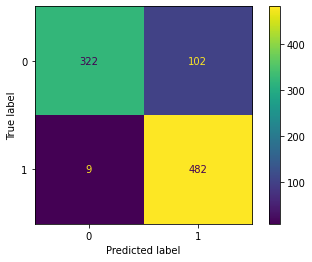

In [ ]:
# confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_label, test_pred_rule)

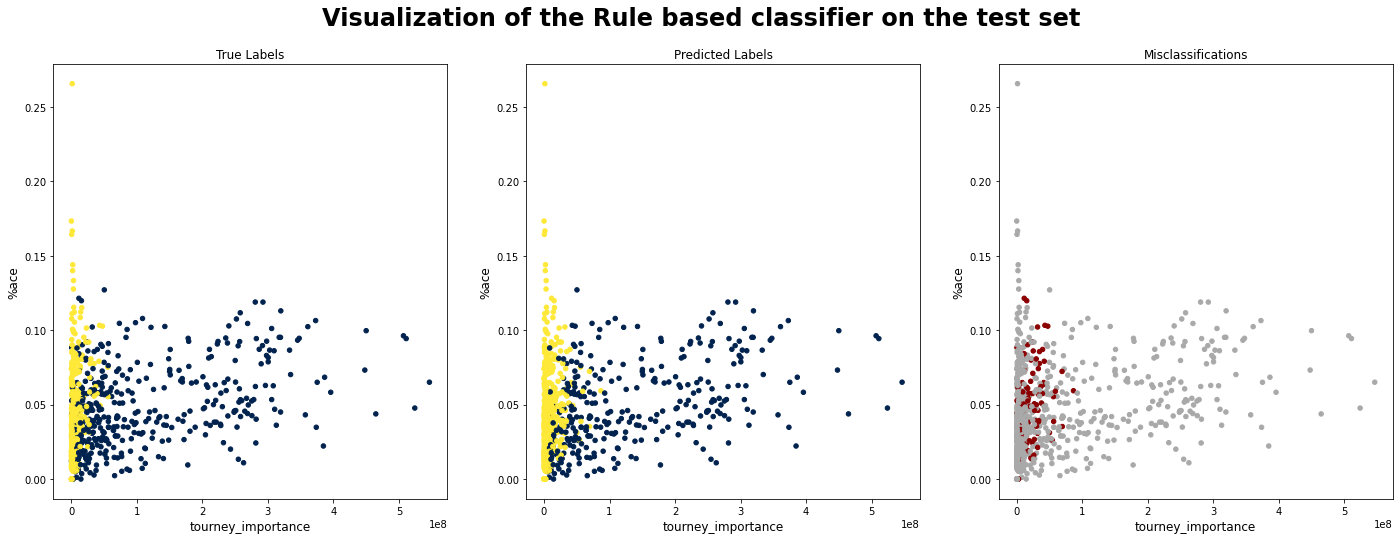

In [ ]:
classification_visualizer(test_set, test_label, test_pred_rule, 'Rule based')

## Final Considerations

Pro:
- As highly understandable as decision trees
- Easy to interpret
- Can classify new instances rapidly
- Performance comparable to decision trees

Cons:
- Imbalanced dataset can cause a bias


# Performance Comparison

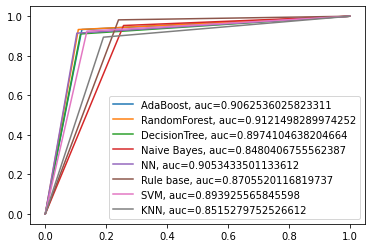

In [ ]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(test_label_dt, test_pred_clf)
auc = metrics.roc_auc_score(test_label_dt, test_pred_clf)
plt.plot(fpr,tpr,label="AdaBoost, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(test_label_dt, test_pred_rf)
auc = metrics.roc_auc_score(test_label_dt, test_pred_rf)
plt.plot(fpr,tpr,label="RandomForest, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(test_label_dt, test_pred_dt)
auc = metrics.roc_auc_score(test_label_dt, test_pred_dt)
plt.plot(fpr,tpr,label="DecisionTree, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_gnb)
auc = metrics.roc_auc_score(test_label, test_pred_gnb)
plt.plot(fpr,tpr,label="Naive Bayes, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_nn)
auc = metrics.roc_auc_score(test_label, test_pred_nn)
plt.plot(fpr,tpr,label="NN, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_rule)
auc = metrics.roc_auc_score(test_label, test_pred_rule)
plt.plot(fpr,tpr,label="Rule base, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(test_label_scaled, test_pred_svm)
auc = metrics.roc_auc_score(test_label_scaled, test_pred_svm)
plt.plot(fpr,tpr,label="SVM, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_knn)
auc = metrics.roc_auc_score(test_label, test_pred_knn)
plt.plot(fpr,tpr,label="KNN, auc="+str(auc))

plt.legend(loc=0)
plt.show()